# Ganopolski 2024- Toward generalized Milankovitch theory 

In [361]:
import pandas as pd
%load_ext autoreload
%autoreload 2
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

from signal_models.g24 import Model3, calc_df, calc_f
from signal_models.forcing import Forcing
from signal_models.solver_util import Solver

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Model 3
From Ganopolski et al. 2024:
`vc` = value for critical ice volume; controls the dominant periodicity and degree of asymmetry of glacial cycles
`f1` = insolation threshold for glacial inception (pinned at -20 to -15 W/m^2)
`t1` = relaxation time scale for glacial inception (in kyr)
`f2` = insolation threshold for deglaciation inception (tunable; positive)
`t2` = relaxation time scale for deglaciation (in kyr)

`A` = magnitude of forcing in Wm−2
`eps` = nondimensional magnitude of amplitude modulation


The code works with: 

t = time in kyr
v = ice volume (nondimensional)
k = state of the system (1 = glacial, 2 = deglaciation)

Within the code, k is calulated according to:

- transition from a glacial (k=1) to deglaciation regime (k = 2) occurs if three conditions are met:
    - v > vc, 
    - dfdt > 0, 
    - f > 0.
        
- The transition from deglaciation (k=2) to glacial (k=1) regime occurs if:
    - f < glaciation threshold f1.
The interglacial state formally belongs to the deglaciation regime.

In [362]:
g24_forcing = Forcing(calc_f, derivative=calc_df)

In [363]:
A = 25
eps = 0.5
f1 = -16
f2 = 16
vc = 1.47
t1 = 30
t2 = 10
vi = 0

In [364]:
model3 = Model3(forcing=g24_forcing, var_name='ice volume', vc=vc, f1=f1, f2=f2, t1=t1, t2=t2)
v_init= 0
k_init = 1

In [389]:
length = 1200
t0 = 0
tend = t0+length
delta_t=6.5

In [399]:
model3.k_arr = [k_init]
model3.t_arr = [0]

model3_euler = Solver(model3, method='euler', t_span=(t0, tend), y0=[v_init, k_init], kwargs={'state_param': True, 'dt':delta_t})
model3_euler.integrate()
tmp_df = pd.DataFrame({'t':np.array(model3.t_arr), 'k':np.array(model3.k_arr)})
tmp_df.drop_duplicates(subset='t', inplace=True)

model3_euler.diagnostics['k_arr'] = np.array(tmp_df['k'])
model3_euler.diagnostics['t_arr'] = np.array(tmp_df['t'])


/Users/jlanders/PycharmProjects/PaleoBeasts/signal_models/g24.py:90: RuntimeWarning: invalid value encountered in sqrt
  def calc_vg(self, f):
/Users/jlanders/PycharmProjects/PaleoBeasts/signal_models/g24.py:96: RuntimeWarning: invalid value encountered in sqrt
  def calc_vu(self, f):


Text(0.5, 0, 'time (kyr)')

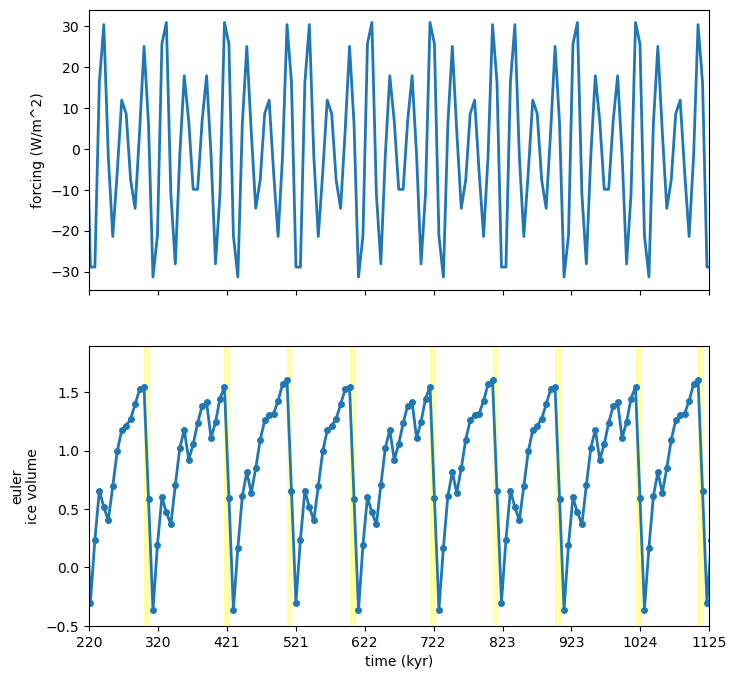

In [400]:
end_kya=75
start_kya=980

model_sols = [model3_euler]
smooth = False
solver_choice = True

t_range = np.arange(max(model_sols[0].solution.t)-start_kya, max(model_sols[0].solution.t)-end_kya, delta_t)
ticks = np.linspace(max(model_sols[0].solution.t)-start_kya, max(model_sols[0].solution.t)-end_kya, 10)  # Generate 6 ticks from 800 to 3000
tick_labels = [str(int(tick)) for tick in ticks]  # Calculate labels 800 to 0

fig, ax = plt.subplots(len(model_sols)+1, 1, sharex=True, figsize=(8, 8))

for ik, model_sol in enumerate(model_sols):
    t_arr = model_sol.diagnostics['t_arr']
    k_arr = model_sol.diagnostics['k_arr']
    
    df = pd.DataFrame({'Time': t_arr, 'k': k_arr})
    df.sort_values('Time', inplace=True)
    df = df[df['Time']>min(t_range)]

    # Identify where 'k' changes
    df['shifted_k'] = df['k'].shift(-1)  # Shift k values down for comparison
    # Start of intervals
    df['start'] = (df['k'] == 2) & (df['k'].shift(1) != 2)
    # End of intervals (note the last interval needs special handling)
    df['end'] = (df['k'] == 2) & (df['shifted_k'] != 2)
    
    # Extract intervals
    intervals = []
    for _, row in df.iterrows():
        if row['start']:
            start_time = row['Time']
        if row['end']:
            end_time = row['Time']
            intervals.append((start_time, end_time))
    
    # Handling case where last interval does not end within the data range
    if df.iloc[-1]['k'] == 2 and not df.iloc[-1]['end']:
        intervals.append((start_time, df.iloc[-1]['Time']))
    
    time = model_sol.solution.t

    model_sol_y = model_sol.solution.y[0]
    model_forcing = model_sol.model.forcing.get_forcing(time)
    label=','.join([model_sol.method, 'solver sampled'])
    ax[ik+1].plot(time, model_sol_y, linewidth=2, marker='o', markersize=4, label=label)
        
    if len(intervals)>0:
        for interval in intervals:
            ax[ik+1].axvspan(interval[0], interval[1], color='yellow', alpha=0.3)
    ax[ik+1].set_xlim([max(model_sol.solution.t)-start_kya, max(model_sol.solution.t)-end_kya])
    
    ax[0].plot(time, model_forcing, linewidth=2, label=label)

    ax[0].set_ylabel('forcing (W/m^2)')
    ax[ik+1].set_xticks(ticks)
    ax[ik+1].set_ylim([-.5,1.9])
    ax[ik+1].set_ylabel('\n'.join([model_sol.method,model_sol.model.variable_name]))
    
ax[-1].set_xticklabels(tick_labels)
ax[-1].set_xlabel('time (kyr)')
